# Project

### Importing necessary libraries for data preprocessing and visualization, model implementation and evaluation

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xg
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

### Load Dataset

In [2]:
df = pd.read_csv('Development Dataset - With Actuals.csv')

In [3]:
# Printing 5 rows of Dataframe
df.head()

,Instrument,Instrument Type,Instrument Subtype,Counterparty Alias,MTM Exposure,Book Exposure,1-Year Likelihood,Severity Used,Industry Alias,Commitment,Country of Incorporation,Maturity Date,Time to Maturity,Capital - EL Tail Risk Contribution (Capped),Capitalization Rate - EL Tail Risk Contribution,Asset Recovery Correlation,Recovery R-Squared for Simulation,Asset R-Squared for Simulation
0,86540,Loan,Term Loan Amortizing,C23099,224013.330,224013.33,0.160200,0.057,IND1,224013.33,CAN,12/15/2037,16.375086,57797.73,0.258010,0.26706,0.34109,0.0976
1,86099,Loan,Revolver,C43055,135000.000,135000.00,0.036900,0.817,IND1,135000.00,CAN,04/18/2022,0.714579,23359.48,0.173033,0.26706,0.34109,0.1077
2,5738,Loan,Term Loan Amortizing,C11421,36190.953,36190.95,0.036900,0.019,IND2,36190.95,CAN,11/17/2031,10.297057,1558.02,0.043050,0.33000,0.34000,0.0469
3,165996,Loan,Term Loan Amortizing,C44251,84600.000,84600.00,0.006525,0.019,IND1,84600.00,CAN,04/03/2028,6.674880,703.86,0.008320,0.26706,0.34109,0.1077
4,118169,Loan,Term Loan Amortizing,C53713,37508.787,37508.78,0.020475,0.247,IND1,37508.78,CAN,01/03/2040,18.425736,3602.36,0.096041,0.33000,0.34000,0.0495


### Understanding and Pre-processing of data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151532 entries, 0 to 151531
Data columns (total 18 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   Instrument                                       151532 non-null  int64  
 1   Instrument Type                                  151532 non-null  object 
 2   Instrument Subtype                               151500 non-null  object 
 3   Counterparty Alias                               151532 non-null  object 
 4   MTM Exposure                                     151532 non-null  float64
 5   Book Exposure                                    151532 non-null  float64
 6   1-Year Likelihood                                151532 non-null  float64
 7   Severity Used                                    151532 non-null  float64
 8   Industry Alias                                   151532 non-null  object 
 9   Commitment     

In [5]:
# Finding number of null values in any column and dropping null records

df.dropna(inplace= True)

columns = df.columns

# Printing unique value in each column
for col in columns:
  print(col.ljust(50), "\t\t\t", len(df[col].unique()))

Instrument                                         			 151500
Instrument Type                                    			 1
Instrument Subtype                                 			 2
Counterparty Alias                                 			 56886
MTM Exposure                                       			 98732
Book Exposure                                      			 99485
1-Year Likelihood                                  			 20
Severity Used                                      			 10
Industry Alias                                     			 38
Commitment                                         			 97558
Country of Incorporation                           			 1
Maturity Date                                      			 4559
Time to Maturity                                   			 4559
Capital - EL Tail Risk Contribution (Capped)       			 130684
Capitalization Rate - EL Tail Risk Contribution    			 151283
Asset Recovery Correlation                         			 981
Recovery R-Squared for Simulation             

In [6]:
# Columns required for model training and evaluation 

# Dropping insignificant categorical columns - Instrument, Instrument Type, Counterparty Alias, Country of Incorporation, Capitalization Rate - EL Tail Risk Contribution

cols_to_use = ['Instrument Subtype', 'MTM Exposure', 'Book Exposure', '1-Year Likelihood', 'Severity Used', 
       'Commitment', 'Time to Maturity', 'Maturity Date',
       'Capital - EL Tail Risk Contribution (Capped)', 'Asset Recovery Correlation', 
       'Recovery R-Squared for Simulation', 'Asset R-Squared for Simulation']
df = df[cols_to_use]
df.head()

,Instrument Subtype,MTM Exposure,Book Exposure,1-Year Likelihood,Severity Used,Commitment,Time to Maturity,Maturity Date,Capital - EL Tail Risk Contribution (Capped),Asset Recovery Correlation,Recovery R-Squared for Simulation,Asset R-Squared for Simulation
0,Term Loan Amortizing,224013.330,224013.33,0.160200,0.057,224013.33,16.375086,12/15/2037,57797.73,0.26706,0.34109,0.0976
1,Revolver,135000.000,135000.00,0.036900,0.817,135000.00,0.714579,04/18/2022,23359.48,0.26706,0.34109,0.1077
2,Term Loan Amortizing,36190.953,36190.95,0.036900,0.019,36190.95,10.297057,11/17/2031,1558.02,0.33000,0.34000,0.0469
3,Term Loan Amortizing,84600.000,84600.00,0.006525,0.019,84600.00,6.674880,04/03/2028,703.86,0.26706,0.34109,0.1077
4,Term Loan Amortizing,37508.787,37508.78,0.020475,0.247,37508.78,18.425736,01/03/2040,3602.36,0.33000,0.34000,0.0495


## Data Pre-processing and Data Visualization

### Correlation Hitmap Plot

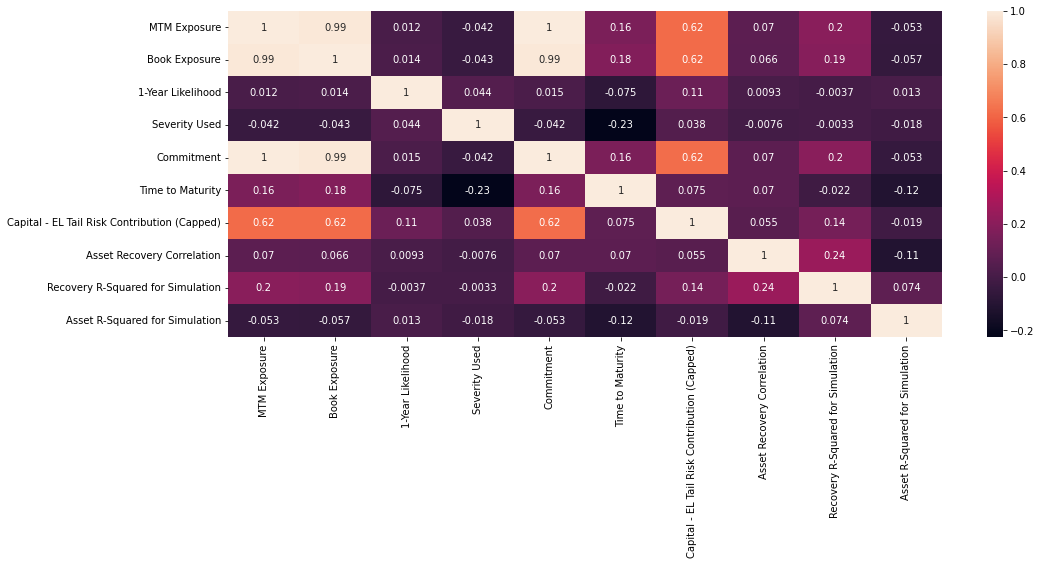

In [7]:
plt.figure(figsize=(16,6))
sns.heatmap(df.corr(), annot=True)
plt.show()

#### As per the above correlation hitmap 'MTM Exporure', 'Book Exposure' and 'Commitment' have same correlation with Capital value, so dropping 'Book Exposure' and 'Commitment'

In [8]:
df.drop(columns = ['Book Exposure', 'Commitment'], inplace = True)
df.columns

Index(['Instrument Subtype', 'MTM Exposure', '1-Year Likelihood',
       'Severity Used', 'Time to Maturity', 'Maturity Date',
       'Capital - EL Tail Risk Contribution (Capped)',
       'Asset Recovery Correlation', 'Recovery R-Squared for Simulation',
       'Asset R-Squared for Simulation'],
      dtype='object')

#### Scatter Plot for Time to Maturity and Maturity Date

In [9]:
# Converting Maturity Date into Datetime datatype
df['Maturity Date'] = pd.to_datetime(df['Maturity Date'])

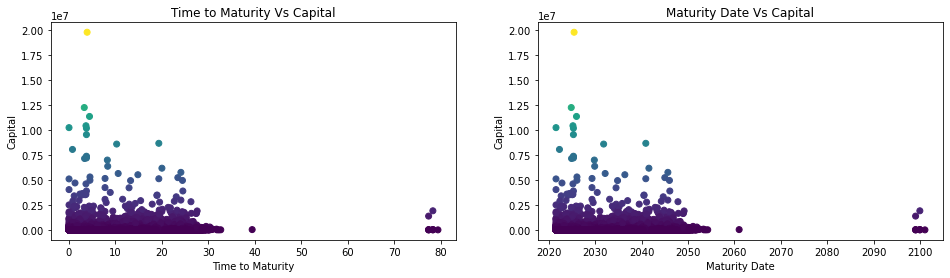

In [10]:
x = df['Time to Maturity']
z = df['Maturity Date']
y = df['Capital - EL Tail Risk Contribution (Capped)']

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(x, y, c = y, cmap = 'viridis')
ax1.set_title('Time to Maturity Vs Capital')
ax1.set_xlabel('Time to Maturity')
ax1.set_ylabel('Capital')

ax2.scatter(z, y, c = y, cmap = 'viridis')
ax2.set_title('Maturity Date Vs Capital')
ax2.set_xlabel('Maturity Date')
ax2.set_ylabel('Capital')

plt.show()

#### As per the scatter plot 'Time to Maturity' and 'Maturity Date' are the similar values, so dropping Maturity Date

In [11]:
df.drop(columns = ['Maturity Date'], inplace = True)
df.columns

Index(['Instrument Subtype', 'MTM Exposure', '1-Year Likelihood',
       'Severity Used', 'Time to Maturity',
       'Capital - EL Tail Risk Contribution (Capped)',
       'Asset Recovery Correlation', 'Recovery R-Squared for Simulation',
       'Asset R-Squared for Simulation'],
      dtype='object')

### Outliers Detection and Removal

#### Scatter Plot and Box Plot for MTM Exposure

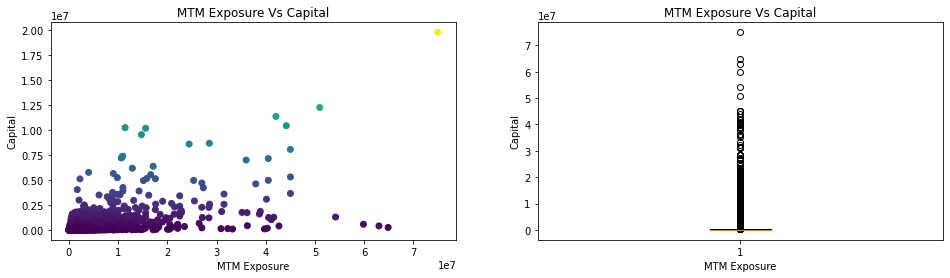

In [12]:
x = df['MTM Exposure']
y = df['Capital - EL Tail Risk Contribution (Capped)']

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(x, y, c = y, cmap = 'viridis')
ax1.set_title('MTM Exposure Vs Capital')
ax1.set_xlabel('MTM Exposure')
ax1.set_ylabel('Capital')

ax2.boxplot(x)
ax2.set_title('MTM Exposure Vs Capital')
ax2.set_xlabel('MTM Exposure')
ax2.set_ylabel('Capital')

plt.show()

#### Removal of outliers in MTM Exposure

In [13]:
lst = ["MTM Exposure"]

for column in lst:
  print("Column :", column)
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1

  print("IQR :", IQR)
  upper_limit = Q1 + (1.5 * IQR)
  lower_limit = Q3 - (1.5 * IQR)
  print("upper_limit :", upper_limit)
  print("lower_limit :", lower_limit)


  df = df[df[column] < upper_limit]
  # df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)

print(len(df))


Column : MTM Exposure
IQR : 198829.3995
upper_limit : 329745.5955
lower_limit : -67913.20349999997
124593


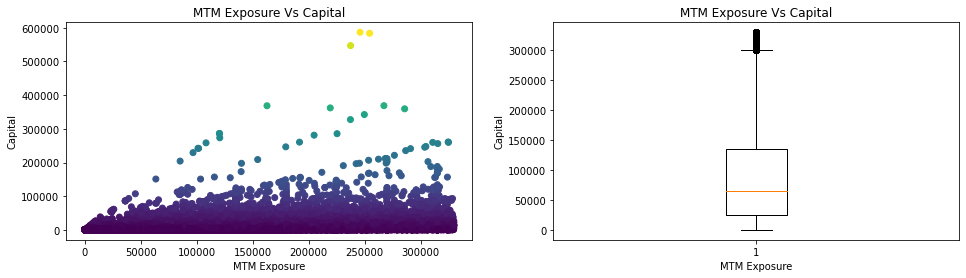

In [14]:
x = df['MTM Exposure']
y = df['Capital - EL Tail Risk Contribution (Capped)']

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(x, y, c = y, cmap = 'viridis')
ax1.set_title('MTM Exposure Vs Capital')
ax1.set_xlabel('MTM Exposure')
ax1.set_ylabel('Capital')

ax2.boxplot(x)
ax2.set_title('MTM Exposure Vs Capital')
ax2.set_xlabel('MTM Exposure')
ax2.set_ylabel('Capital')

plt.show()

#### Scatter Plot and Box Plot for Time to Maturity

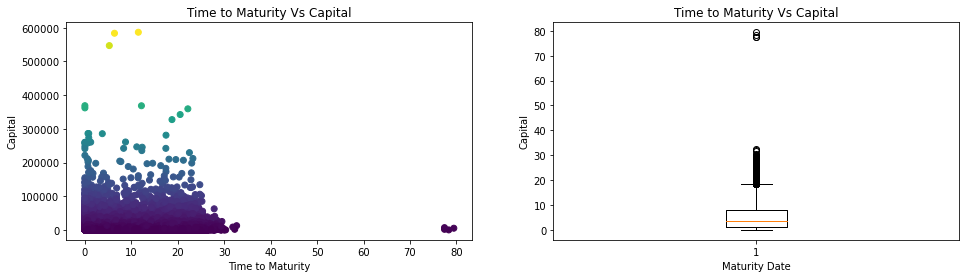

In [15]:
x = df['Time to Maturity']
y = df['Capital - EL Tail Risk Contribution (Capped)']

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(x, y, c = y, cmap = 'viridis')
ax1.set_title('Time to Maturity Vs Capital')
ax1.set_xlabel('Time to Maturity')
ax1.set_ylabel('Capital')

ax2.boxplot(x)
ax2.set_title('Time to Maturity Vs Capital')
ax2.set_xlabel('Maturity Date')
ax2.set_ylabel('Capital')

plt.show()

#### Removal of outliers in Time to Maturity

In [16]:
outlier_index = df['Time to Maturity'].sort_values(ascending=False).head(9).index
df.drop(index = outlier_index,axis=0,inplace=True)

print(len(df))

124584


In [17]:
outlier_index = df['Capital - EL Tail Risk Contribution (Capped)'].sort_values(ascending=False).head(800).index
df.drop(index = outlier_index,axis=0,inplace=True)
outlier_index

Int64Index([137422,  19537, 125877, 147050, 101749,  17076, 108405,  62158,
             10845,  19357,
            ...
             21663,  45665,  88962, 132850, 116764,   5668,  41997,  58996,
            128752,  15426],
           dtype='int64', length=800)

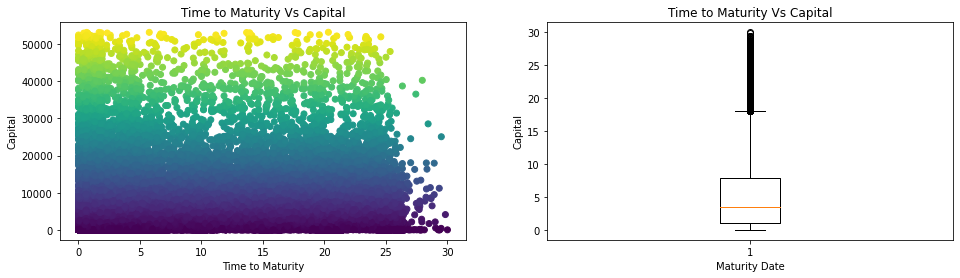

In [18]:
x = df['Time to Maturity']
y = df['Capital - EL Tail Risk Contribution (Capped)']

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(x, y, c = y, cmap = 'viridis')
ax1.set_title('Time to Maturity Vs Capital')
ax1.set_xlabel('Time to Maturity')
ax1.set_ylabel('Capital')

ax2.boxplot(x)
ax2.set_title('Time to Maturity Vs Capital')
ax2.set_xlabel('Maturity Date')
ax2.set_ylabel('Capital')

plt.show()

#### Scatter Plot and Box Plot for Asset Recovery Correlation

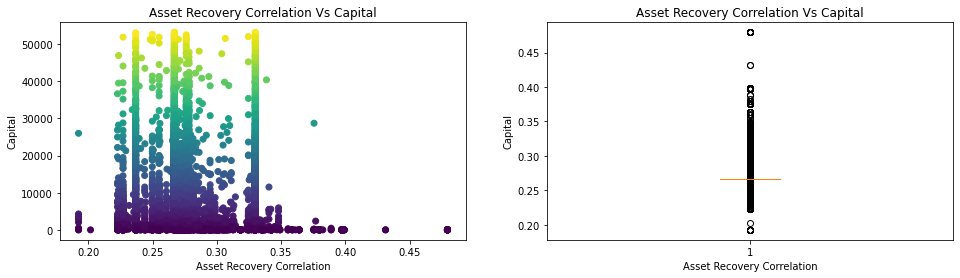

In [19]:
x = df['Asset Recovery Correlation']
y = df['Capital - EL Tail Risk Contribution (Capped)']

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(x, y, c = y, cmap = 'viridis')
ax1.set_title('Asset Recovery Correlation Vs Capital')
ax1.set_xlabel('Asset Recovery Correlation')
ax1.set_ylabel('Capital')

ax2.boxplot(x)
ax2.set_title('Asset Recovery Correlation Vs Capital')
ax2.set_xlabel('Asset Recovery Correlation')
ax2.set_ylabel('Capital')

plt.show()

#### Removal of outliers in Asset Recovery Correlation

In [20]:
outlier_index = df['Asset Recovery Correlation'].sort_values(ascending=False).head(150).index
df.drop(index = outlier_index,axis=0,inplace=True)
outlier_index

Int64Index([127985,  13727,  18046,  57333,  27764, 134085,  92705,  90046,
             90258, 107285,
            ...
             78616,  68368,  27589, 129892,  22010,  82045,  24572,  64582,
            122184,  72624],
           dtype='int64', length=150)

#### Scatter Plot and Box Plot for Severity Used

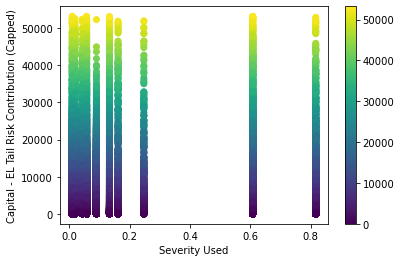

In [21]:
x = df['Severity Used']
y = df['Capital - EL Tail Risk Contribution (Capped)']

plt.scatter( x, y, c=y, cmap='viridis')
plt.colorbar()
plt.xlabel(x.name)
plt.ylabel(y.name)
plt.show()

### One-Hot encoding of categorical columns

#### Scatter Plot for 1-Year Likelihood

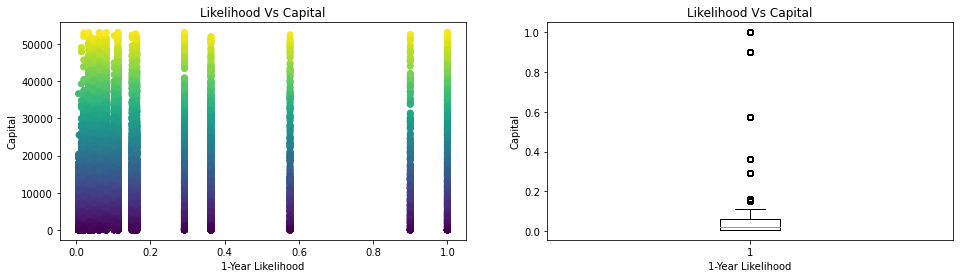

In [22]:
x = df['1-Year Likelihood']
y = df['Capital - EL Tail Risk Contribution (Capped)']

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(x, y, c = y, cmap = 'viridis')
ax1.set_title('Likelihood Vs Capital')
ax1.set_xlabel('1-Year Likelihood')
ax1.set_ylabel('Capital')

ax2.boxplot(x)
ax2.set_title('Likelihood Vs Capital')
ax2.set_xlabel('1-Year Likelihood')
ax2.set_ylabel('Capital')

plt.show()

In [23]:
print('Unique Values in Likelihood : ', df['1-Year Likelihood'].unique())
print('Unique Values in Instrument Subtype : ', df['Instrument Subtype'].unique())

Unique Values in Likelihood :  [0.0369     0.006525   0.020475   0.0207     0.06254999 0.10237499
 0.01439999 0.15097499 0.1602     0.04544999 0.00809999 0.03397499
 0.11272499 0.08122499 0.16335    0.36315    1.         0.291825
 0.9        0.576225  ]
Unique Values in Instrument Subtype :  ['Revolver' 'Term Loan Amortizing']


#### One-Hot encoding of Instrument Subtype and 1-Year Likelihood 

In [24]:
df = pd.get_dummies(df, columns=['Instrument Subtype', '1-Year Likelihood'],drop_first=True)
print(df.shape)

(123634, 27)


In [25]:
df.shape

(123634, 27)

## Feature Selection

#### Selecting features and setting input and output variables

In [31]:
input_columns = [column for column in df.columns if column != "Capital - EL Tail Risk Contribution (Capped)"]
output_column = ['Capital - EL Tail Risk Contribution (Capped)']

X = df[input_columns]
y = df[output_column]

In [32]:
print(input_columns)
print(output_column)

['MTM Exposure', 'Severity Used', 'Time to Maturity', 'Asset Recovery Correlation', 'Recovery R-Squared for Simulation', 'Asset R-Squared for Simulation', 'Instrument Subtype_Term Loan Amortizing', '1-Year Likelihood_0.00809999', '1-Year Likelihood_0.01439999', '1-Year Likelihood_0.020475', '1-Year Likelihood_0.0207', '1-Year Likelihood_0.03397499', '1-Year Likelihood_0.0369', '1-Year Likelihood_0.04544999', '1-Year Likelihood_0.06254999', '1-Year Likelihood_0.08122499', '1-Year Likelihood_0.10237499', '1-Year Likelihood_0.11272499', '1-Year Likelihood_0.15097499', '1-Year Likelihood_0.1602', '1-Year Likelihood_0.16335', '1-Year Likelihood_0.291825', '1-Year Likelihood_0.36315', '1-Year Likelihood_0.576225', '1-Year Likelihood_0.9', '1-Year Likelihood_1.0']
['Capital - EL Tail Risk Contribution (Capped)']


## Model Implementation

#### Split the input and target variables into train and test set

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [33]:
print("X_train :", X_train.columns)
print("X_test :", X_test.columns)
print("y_train :", y_train.columns)
print("y_test :", y_test.columns)

X_train : Index(['MTM Exposure', 'Severity Used', 'Time to Maturity',
       'Asset Recovery Correlation', 'Recovery R-Squared for Simulation',
       'Asset R-Squared for Simulation',
       'Instrument Subtype_Term Loan Amortizing',
       '1-Year Likelihood_0.00809999', '1-Year Likelihood_0.01439999',
       '1-Year Likelihood_0.020475', '1-Year Likelihood_0.0207',
       '1-Year Likelihood_0.03397499', '1-Year Likelihood_0.0369',
       '1-Year Likelihood_0.04544999', '1-Year Likelihood_0.06254999',
       '1-Year Likelihood_0.08122499', '1-Year Likelihood_0.10237499',
       '1-Year Likelihood_0.11272499', '1-Year Likelihood_0.15097499',
       '1-Year Likelihood_0.1602', '1-Year Likelihood_0.16335',
       '1-Year Likelihood_0.291825', '1-Year Likelihood_0.36315',
       '1-Year Likelihood_0.576225', '1-Year Likelihood_0.9',
       '1-Year Likelihood_1.0'],
      dtype='object')
X_test : Index(['MTM Exposure', 'Severity Used', 'Time to Maturity',
       'Asset Recovery Correlatio

### Standardization of Train and Test Data

In [34]:
scaler = StandardScaler()
# transform data

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42)

for i in train_columns:
# fit on training data column
    scale = StandardScaler().fit(X_train[[i]])
# transform the training data column
    X_train[i] = scale.transform(X_train[[i]])
# transform the testing data column
    X_test[i] = scale.transform(X_test[[i]])

## Implementation of Linear Regression Model

#### Creating model object and fit the train data into it

In [44]:
linear_reg_model = LinearRegression()
  
linear_reg_model.fit(X_train, y_train)

LinearRegression()

#### Model evaluation

In [45]:
y_pred = linear_reg_model.predict(X_test)
r2_score = linear_reg_model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression")
print("R2 Score : ", r2_score)
print("Mean Absolute Error : ", mae)

Linear Regression
R2 Score :  0.521207753245746
Mean Absolute Error :  2551.490227979292


## Implementation of Decision Tree Model

#### Creating model object and fit the train data into it

In [46]:
dtree_model = tree.DecisionTreeRegressor(max_depth = 15)

dtree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=15)

#### Model evaluation

In [47]:
y_pred = dtree_model.predict(X_test)
r2_score = dtree_model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
print("Decision Tree Regression")
print("R2 Score : ", r2_score)
print("Mean Absolute Error : ", mae)

Decision Tree Regression
R2 Score :  0.8450640924340727
Mean Absolute Error :  1200.0463133679534


## Implementation of Random Forest Model

#### Creating model object and fit the train data into it

In [52]:
rforest_model = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, max_features=0.5)

rforest_model.fit(X_train, y_train)

/var/folders/j4/19v5bck14f94qj1scfkf1m5m0000gn/T/ipykernel_14079/1805938944.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rforest_model.fit(X_train, y_train)


RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1)

#### Model evaluation

In [53]:
y_pred = rforest_model.predict(X_test)
r2_score = rforest_model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
print("Random Forest Regression")
print("R2 Score : ", r2_score)
print("Mean Absolute Error : ", mae)

Random Forest Regression
R2 Score :  0.8915095568895646
Mean Absolute Error :  929.7067533774836


## Implementation of Gradient Boosting Model

#### Creating model object and fit the train data into it

In [61]:
gb_model = GradientBoostingRegressor(random_state=40)
gb_model.fit(X_train, y_train)

/Users/vrunda/miniforge3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(random_state=40)

#### Model evaluation

In [62]:
y_pred = gb_model.predict(X_test)
r2_score = gb_model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
print("Gradient Boosting Regression")
print("R2 Score : ", r2_score)
print("Mean Absolute Error : ", mae)

Gradient Boosting Regression
R2 Score :  0.7734291891002654
Mean Absolute Error :  1545.353763457095


## Implementation of XG Boost Regressor Model

#### Creating model object and fit the train data into it

In [63]:
xgb_r = xg.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 40, seed = 123)
xgb_r.fit(X_train, y_train)

/Users/vrunda/miniforge3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=40, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

#### Model evaluation

In [64]:
y_pred = xgb_r.predict(X_test)
r2_score = xgb_r.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
print("XG Boost Regression")
print("R2 Score : ", r2_score)
print("Mean Absolute Error : ", mae)

XG Boost Regression
R2 Score :  0.902864045957015
Mean Absolute Error :  1023.8273278682838


## Implementation of Deep Neural Network Model

In [69]:
dnn_model = keras.Sequential()
dnn_model.add(layers.Dense(100, activation='relu', input_dim = 26))
dnn_model.add(layers.Dense(50, activation='relu'))
dnn_model.add(layers.Dense(10, activation='relu'))
dnn_model.add(layers.Dense(1, activation='linear'))

dnn_model.compile(loss='mean_absolute_error',
                optimizer='adam', metrics = ['mean_absolute_error'])

In [71]:
history = dnn_model.fit(X_train, y_train, epochs = 25, validation_split=0.2)

Epoch 1/25
  23/2164 [..............................] - ETA: 10s - loss: 4061.0039 - mean_absolute_error: 4061.0039

2022-04-11 23:54:00.178108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2160/2164 [============================>.] - ETA: 0s - loss: 2181.4285 - mean_absolute_error: 2181.4285

2022-04-11 23:54:09.830500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2164/2164 [==============================] - 11s 5ms/step - loss: 2180.5503 - mean_absolute_error: 2180.5503 - val_loss: 1715.4563 - val_mean_absolute_error: 1715.4563
Epoch 2/25
2164/2164 [==============================] - 11s 5ms/step - loss: 1546.7206 - mean_absolute_error: 1546.7206 - val_loss: 1520.8307 - val_mean_absolute_error: 1520.8307
Epoch 3/25
2164/2164 [==============================] - 11s 5ms/step - loss: 1408.8190 - mean_absolute_error: 1408.8190 - val_loss: 1425.8394 - val_mean_absolute_error: 1425.8394
Epoch 4/25
2164/2164 [==============================] - 12s 5ms/step - loss: 1327.6302 - mean_absolute_error: 1327.6302 - val_loss: 1353.1250 - val_mean_absolute_error: 1353.1250
Epoch 5/25
2164/2164 [==============================] - 10s 5ms/step - loss: 1265.0710 - mean_absolute_error: 1265.0710 - val_loss: 1282.2336 - val_mean_absolute_error: 1282.2336
Epoch 6/25
2164/2164 [==============================] - 10s 5ms/step - loss: 1216.1938 - mean_absolute_error: 1216.1

In [74]:
y_pred = dnn_model.predict(X_test)
r2_score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Deep Neural Network Regression")
print("R2 Score : ", r2_score)
print("Mean Absolute Error : ", mae)

Deep Neural Network Regression
R2 Score :  0.8604091044740052
Mean Absolute Error :  1032.2152774134981
